# Example of pseudotime ordering: video

## Loading needed modules

In [1]:
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import scanpy as sc

## Load images and convert to greyscale

In [2]:
files=glob.glob('frames/*.jpg')

In [3]:
def rgb2gray(path):
    return np.dot(mpimg.imread(path)[...,:3], [0.2989, 0.5870, 0.1140]).ravel()

mat=np.vstack(list(map(rgb2gray,files)))

## Generate a "single cell" dataset using AnnData object

The loading of the data generated a matrix `mat` of 349 frames (rows) with 230400 pixels (columns) for each frames, we can assign this matrix simply to an AnnData object by calling:

In [4]:
adata=sc.AnnData(mat)

In [5]:
adata

AnnData object with n_obs × n_vars = 349 × 230400

Let's get some rough estimate of the time of sampling, in this experiment we need at which second the frame has been extracted:

In [6]:
adata.obs["sec"]=[round(int(f.split("_")[1].split(".")[0])/30) for f in files]
adata.obs["sec"]=adata.obs["sec"].astype("category")

## Perform PCA on the scaled dataset

We can now perform PCA on the scaled dataset, with `pp.scale` and `pp.pca` from `scanpy`. 

In [7]:
adata.obsm["X_pca"]=sc.pp.pca(sc.pp.scale(adata.X,copy=True),n_comps=20)

We can visualise the two first PCs as these contains the two most informative dimensions:

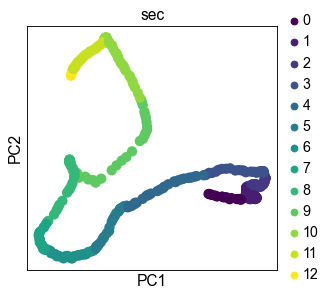

In [8]:
sc.set_figure_params()
sc.pl.pca(adata,color='sec',palette="viridis")

Intriguing! We see a trajectory emerging, and our rough time estimate seems to consitently follow this path!

## Infer a trajectory

We are going to fit a trajectory in order to recover the order of the frames, to do so we will using `scFates` suite, which includes ElPiGraph.

ElPiGraph learns trajectories by inferring a principal graph composed of several nodes, the nodes aims to fit the datapoints as much as possible while follwoing some "grammars" dictating how the overall structure should behave.

In this case we infer a 30 nodes principal curve in PCA space.

In [9]:
import scFates as scf

In [10]:
scf.tl.curve(adata,use_rep='X_pca',Nodes=30,seed=42)

inferring a principal tree --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] hard assignment of cells to principal point in representation space.
    .uns['graph']['F'], coordinates of principal points in representation space.


## Visualise the trajectory

We can project the resulting principal curve onto our 2 first PC components:

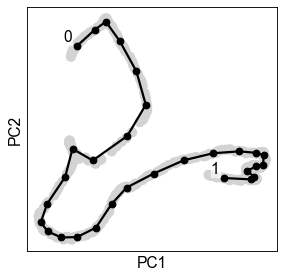

In [11]:
scf.pl.graph(adata,basis="pca")

The curve seems to fit pretty well our data!

## Select a root and order the observations

By default the tip and fork ids of the principal graph are shown on the plot, here since we have a curve we only get two tips. We can now choose one of them to make it as the starting point or the root of our trajectory. Here it is easy has we already got the rough estimate of the time. 

In [12]:
scf.tl.root(adata,1)

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


We now calculate the pseudotime, by projecting the observations along the trajectory, and by assigning a distance from the selected root as the pseudotime value.

In [13]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


## Visualise pseudotime and compare with the "real" time

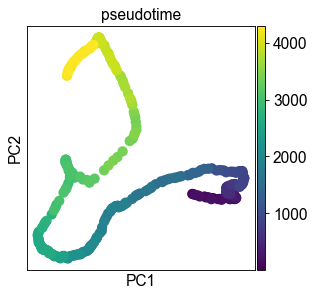

In [14]:
sc.pl.pca(adata,color="t",title='pseudotime')

Let's compare the real time with the recovered pseudotime, both variables correlates pretty well!

Text(0.5, 0, 'pseudotime')

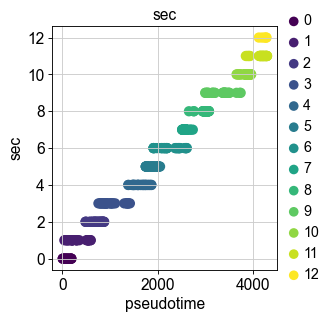

In [15]:
ax=sc.pl.scatter(adata,x="t",y="sec",color="sec",show=False)
ax.set_xlabel("pseudotime")

Hooray! We have recovered the lost ordering of our frame, we can now enjoy the video!